<a href="https://colab.research.google.com/github/stomioka/phuse-tumor-ml/blob/master/07_dual_cnn_tumor_prediction_sites_central_google_cola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Response criteria prediction for tumor with parallel-CNN

Sam Tomioka<br>
2019-10-13

Same data used in [notebook3](03-tumor_prediction-sites-central.ipynb) will be used here. 

- Model based on `central`+`site` with 85% of data from each. Test on remaining `central` assessments, Test on remaining `site` assessments independently.

In [0]:
#!pip install git+git://github.com/andirs/impyte.git
#!pip install xgboost 

!git clone https://github.com/stomioka/phuse-tumor-ml.git
!pip install git+git://github.com/andirs/impyte.git
!mv phuse-tumor-ml phuse_tumor_ml

Cloning into 'phuse-tumor-ml'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 118 (delta 56), reused 79 (delta 22), pack-reused 0
Receiving objects: 100% (118/118), 3.48 MiB | 7.05 MiB/s, done.
Resolving deltas: 100% (56/56), done.
  Cloning git://github.com/andirs/impyte.git to /tmp/pip-req-build-e4i8tx8p
  Running command git clone -q git://github.com/andirs/impyte.git /tmp/pip-req-build-e4i8tx8p
  Created wheel for impyte: filename=impyte-0.1.0-cp36-none-any.whl size=21388 sha256=5ec16c677856070dc7d5308d2abdb8b36e2648d0c621b24cf3ad1ab81256dcb9
  Stored in directory: /tmp/pip-ephem-wheel-cache-mbmcd4sj/wheels/65/16/30/1a24d053bf050146af36c12fdca5e3f2362d892226909931e4
Successfully built impyte


In [0]:
import os
os.chdir('phuse_tumor_ml/notebooks')
from lib.myutil import *
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.train import *
print('tensorflow version: {}'.format(tf.__version__))

import sklearn
from sklearn.metrics import accuracy_score,roc_curve, auc
print('sklearn version: {}'.format(sklearn.__version__))
import matplotlib.pyplot as plt
%matplotlib inline

tf.enable_eager_execution()

#tf.keras.backend.clear_session() 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


tensorflow version: 1.15.0-rc3
sklearn version: 0.21.3


In [0]:
central, site=load_data()

tr_x, tr_y, ts_x, ts_y, ts_x2, ts_y2 = generate_tr_ts(df1=central, df2=site, m=3, method=None, h=3000, seed=2019)

In [0]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
tr_y = encoder.fit_transform(tr_y)
ts_y = encoder.fit_transform(ts_y)
ts_y2 = encoder.fit_transform(ts_y2)

In [0]:
tr_x.shape, tr_y.shape
x_train, x_vl, y_train, y_vl = train_test_split(tr_x, tr_y, test_size=0.20, random_state=2019)
print()
x_train=np.array(x_train).reshape(x_train.shape[0],7,1)
#y_train=np.array(y_train).reshape(y_train.shape[0],5,1)
x_vl=np.array(x_vl).reshape(x_vl.shape[0],7,1)
#y_vl=np.array(y_vl).reshape(y_vl.shape[0],5,1)

In [0]:
tf.keras.backend.clear_session() 
i = Input(shape=(7,1),name='recest')

x0 = Conv1D(64, 3, activation='relu', name='1Dconv_1')(i)
x0 = Conv1D(64, 3, activation='relu', name='1Dconv_2')(x0)
x0 = Dropout(0.5, name='1Dropout')(x0)
x0 = MaxPooling1D(pool_size=2, name='1maxpool')(x0)
x0 = Flatten()(x0)
x0 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='1out')(x0)

x1 = Conv1D(128, 3, activation='relu', name='2Dconv_1')(i)
x1 = Conv1D(128, 3, activation='relu', name='2Dconv_2')(x1)
x1 = Dropout(0.5, name='2Dropout')(x1)
x1 = MaxPooling1D(pool_size=2, name='2maxpool')(x1)
x1 = Flatten()(x1)
x1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='2out')(x1)


#x1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='dense_2')(i)
x2 = Add()([x0, x1])
x2 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='dense_1')(x2)
#x2 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='dense_2')(x2)
#x2 = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='dense_3')(x2)
x2 = Flatten()(x2)
outputs = Dense(5, activation='softmax', name='pred')(x2)

model = Model(i, outputs)
opt = AdamOptimizer(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
recest (InputLayer)             [(None, 7, 1)]       0                                            
__________________________________________________________________________________________________
1Dconv_1 (Conv1D)               (None, 5, 64)        256         recest[0][0]                     
__________________________________________________________________________________________________
2Dconv_1 (Conv1D)               (None, 5, 128)       512         recest[0][0]                     
__________________________________________________________________________________________________
1Dconv_2 (Conv1D)               (None, 3, 64)        12352       1Dconv_1[0][0]                   
______________________________________________________________________________________________

In [0]:
history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=500,

                    validation_data=(x_vl, y_vl))

Train on 1098 samples, validate on 275 samples
Epoch 1/500
1098/1098 [==============================] - 1s 880us/sample - loss: 2.5039 - acc: 0.6066 - val_loss: 1.7168 - val_acc: 0.7455
Epoch 2/500
1098/1098 [==============================] - 0s 290us/sample - loss: 1.4421 - acc: 0.7313 - val_loss: 1.2473 - val_acc: 0.7382
Epoch 3/500
1098/1098 [==============================] - 0s 290us/sample - loss: 1.1073 - acc: 0.7568 - val_loss: 1.0322 - val_acc: 0.7636
Epoch 4/500
1098/1098 [==============================] - 0s 283us/sample - loss: 0.9335 - acc: 0.7668 - val_loss: 0.8757 - val_acc: 0.7964
Epoch 5/500
1098/1098 [==============================] - 0s 276us/sample - loss: 0.8225 - acc: 0.7860 - val_loss: 0.8079 - val_acc: 0.8036
Epoch 6/500
1098/1098 [==============================] - 0s 278us/sample - loss: 0.7499 - acc: 0.8169 - val_loss: 0.7396 - val_acc: 0.8218
Epoch 7/500
1098/1098 [==============================] - 0s 268us/sample - loss: 0.7094 - acc: 0.8069 - val_loss: 0.723

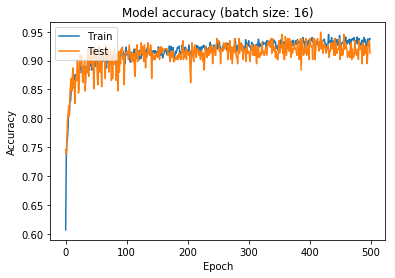

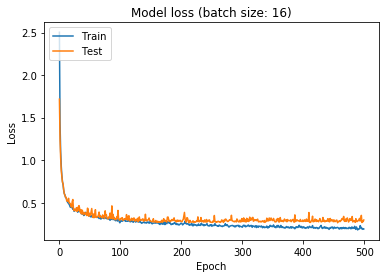

In [0]:
plot_hist(history)

In [0]:
ts_x=np.array(ts_x).reshape(ts_x.shape[0],7,1)
results1=model.evaluate(ts_x, ts_y, batch_size=32)
print('\nm=3, test=C\n test loss: {}\n  test acc: {}'.format(results1[0],results1[1]))

138/138 [==============================] - 0s 956us/sample - loss: 0.3804 - acc: 0.8623

m=3, test=C
 test loss: 0.38041798694842105
  test acc: 0.8623188138008118


In [0]:
ts_x2=np.array(ts_x2).reshape(ts_x2.shape[0],7,1)
results2=model.evaluate(ts_x2, ts_y2, batch_size=32)
print('\nm=3, test=D\n test loss: {}\n  test acc: {}'.format(results2[0],results2[1]))

104/104 [==============================] - 0s 688us/sample - loss: 0.1765 - acc: 0.9808

m=3, test=D
 test loss: 0.17650621470350486
  test acc: 0.9807692170143127


In [0]:
## check where model did not predict correctly

In [0]:
_, _, ts_x_df, ts_y_lbl, ts_x2_df, ts_y2_lbl = generate_tr_ts(df1=central, df2=site, m=3, method=None, h=3000, seed=2019, normalize=False)

TypeError: ignored

In [0]:
def prediction(encoder, model, test_x):
    pred=model.predict(test_x)
    return encoder.inverse_transform(np.round(pred))
def return_predict(encoder, model, test_x, test_y):
    pred=prediction(encoder, model, test_x)
    results=[pred==true for pred, true in list(zip(pred,test_y))]
    return results

In [0]:
ts_x_df['Label']=ts_y_lbl['TRGRESP']
ts_x_df['Pred']=prediction(encoder, model, ts_x)
ts_x_df['Correct']=return_predict(encoder, model, ts_x, ts_y_lbl['TRGRESP'])
ts_x_df

In [0]:
ts_x2_df['Label']=ts_y2_lbl['TRGRESP']
ts_x2_df['Pred']=prediction(encoder, model, ts_x2)
ts_x2_df['Correct']=return_predict(encoder, model, ts_x2, ts_y2_lbl['TRGRESP'])
ts_x2_df